In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In this notebook, we will explore several types of Regression models on a Medical Cost dataset found on Kaggle( https://www.kaggle.com/mirichoi0218/insurance ) to see if we can predict if certain factors can predict medical costs. This data set shows individual medical costs as billed by insurance. The identity of each individual is hidden but some personal data is given such as: age, sex, BMI, how many children they have, if they are as smoker, and what region they are from. We have no data on the diagnosis of patients. But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis.

Let's Start With Exploratory Data Analysis (EDA)!

In [2]:
#Load data
csv_url = 'https://raw.githubusercontent.com/mkung8889/ML_Regression/master/insurance.csv'
df = pd.read_csv(csv_url)

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
#Check for any null values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There is no NaN values, so no need to use SciKit Imputer to handle missing data in the dataset.

Let's first take a look at "charges"

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


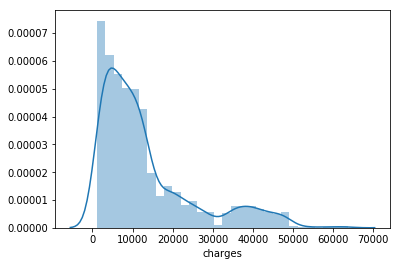

In [5]:
print(df.charges.describe())
sns.distplot(df.charges)

We can see there is quite a range of charges, from 1121.8 all the way to 63770.42. It seems a large majority of charges are 16,639.91 or lower.  

Now lets use LabelEncoder to encode categorical features ('sex', 'region').
Don't worry, e will use OneHotEncoder later before we start modeling.

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['region'] = le.fit_transform(df['region'])

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Now lets look at correlation between features!

In [8]:
df.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

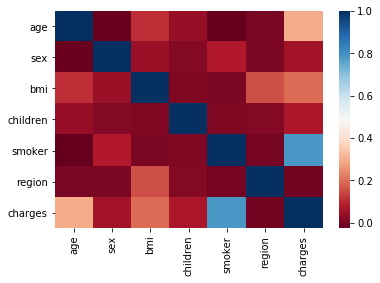

In [23]:
sns.heatmap(df.corr(), cmap='RdBu')

We see there is a strong correlation between 'smoker' and 'charges'. I would have expected bmi to also be highly correlated to charges. 

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

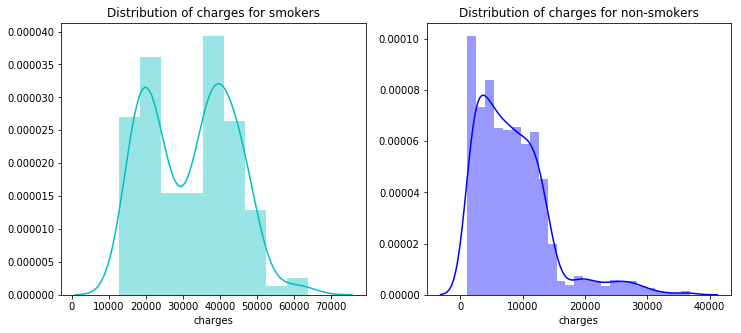

In [41]:
f= plt.figure(figsize=(12,5))

ax1=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='c',ax=ax1)
ax1.set_title('Distribution of charges for smokers')

ax2=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='b',ax=ax2)
ax2.set_title('Distribution of charges for non-smokers')

We can see smokers' charge range much higher than non-smokers. But lets see how many smokers and non-smokers there are.

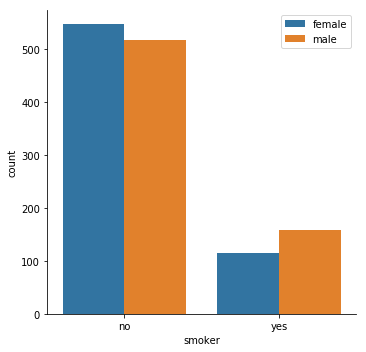

In [65]:
sns.catplot(x='smoker',hue='sex', kind='count', legend=False, data=df)
plt.xticks(np.arange(2), labels=['no', 'yes'])
plt.legend(labels=('female', 'male'))
plt.show()

We can see there are much more non-smokers than smokers. We can also see there are more male smokers than female.

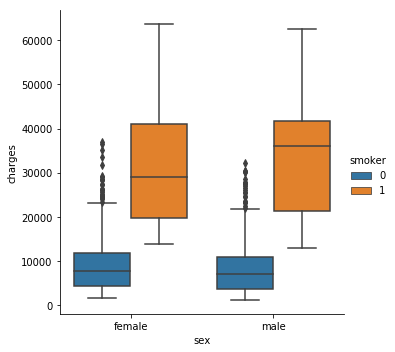

In [75]:
sns.catplot(x="sex", y="charges", hue="smoker", kind="box", data=df)
plt.xticks(np.arange(2), labels=['female', 'male'])
plt.show()

Here we see that, smokers indeed have the higher charges independent of sex. As expected there are outliers in the non-smoker group who have higher medical charges, possibly due to accidents or serious disease etc. 

Now that we have looked closer at the smoker feature, lets start looking into the other variables.
Let's start with age:

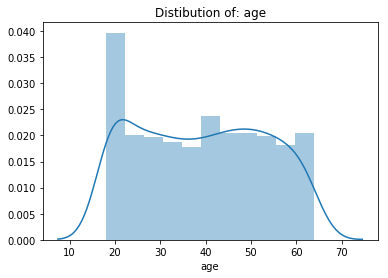

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64
young (18-33): 523
middle (34-48): 402
older(49-64): 413

18 69
19 68
20 29
21 28


In [104]:
sns.distplot(df.age)
plt.title('Distibution of: age')
plt.show()
print(df.age.describe())
print("""young (18-33): {}
middle (34-48): {}
older(49-64): {}
""".format(df['age'].loc[(df['age']>=18) & (df['age']<34)].count(), 
           df['age'].loc[(df['age']>=34) & (df['age']<49)].count(), 
           df['age'].loc[(df['age']>=49) & (df['age']<65)].count()
          ))
for i in range(18,22):
    print(i, df['age'].loc[df['age']==i].count())

We see the age range is 18 to 64 with a mean age of 39. There are more much more 18 and 19 year olds than any other age. 